In [1]:
import torch
from torchvision import transforms, models
from datasets import load_dataset
import time
import numpy as np
import matplotlib.pyplot as plt

/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set seed for reproducibility in torch, numpy and gpu

torch.manual_seed(710)
np.random.seed(710)




In [3]:
tiny_imagenet = load_dataset("Maysee/tiny-imagenet", split="train")
tiny_imagenet[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 'label': 0}

In [5]:
len(tiny_imagenet)

100000

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [5]:
# Convert to torch dataset

class TinyImageNet(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]["image"], self.dataset[idx]["label"]
        # convert x to RGB
        x = x.convert("RGB")
        if self.transform:
            x = self.transform(x)
        y = torch.tensor(y, dtype=torch.int64)
        return x, y

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

tiny_imagenet_torch = TinyImageNet(tiny_imagenet, transform=transform)
type(tiny_imagenet_torch[0])

tuple

### Compare effect of number of workers on data size

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


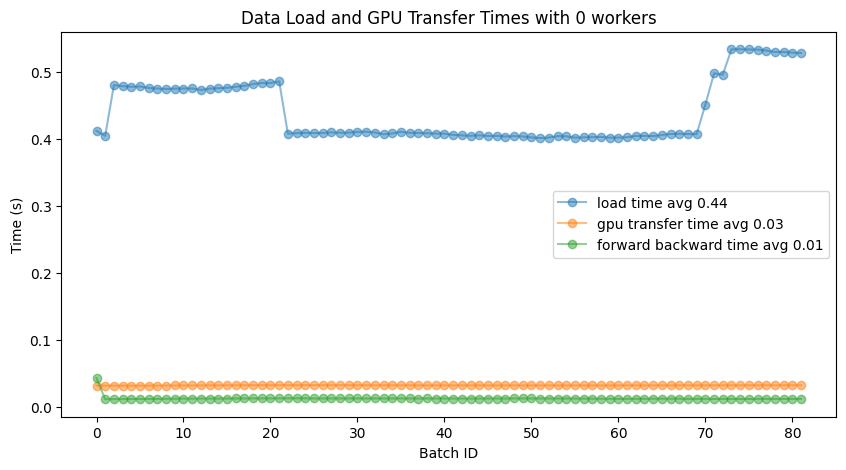

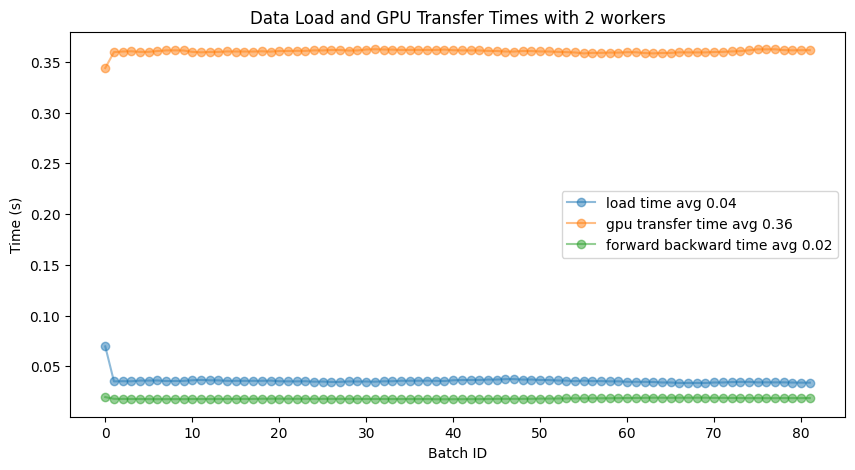

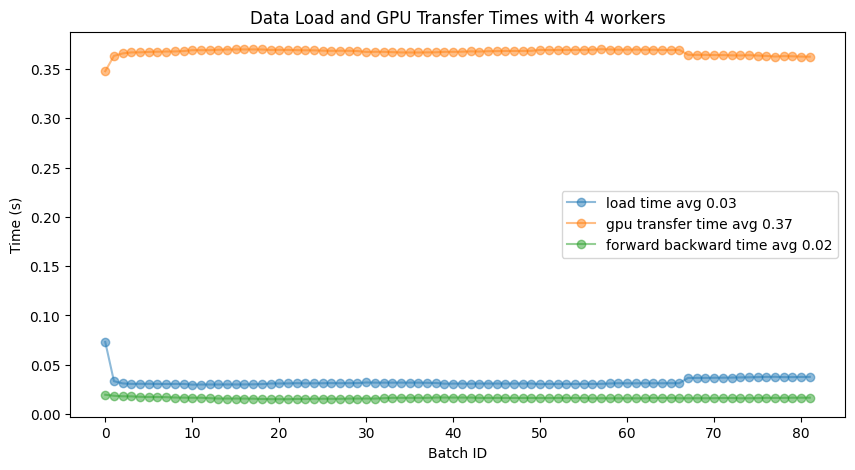

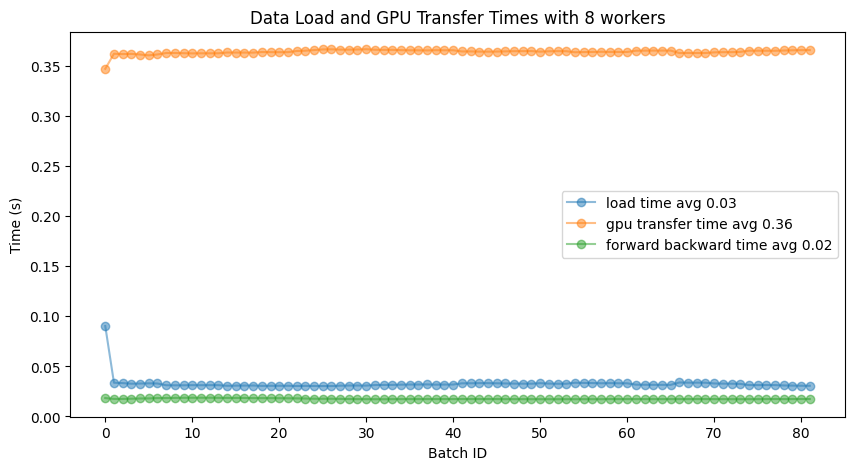

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 14, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


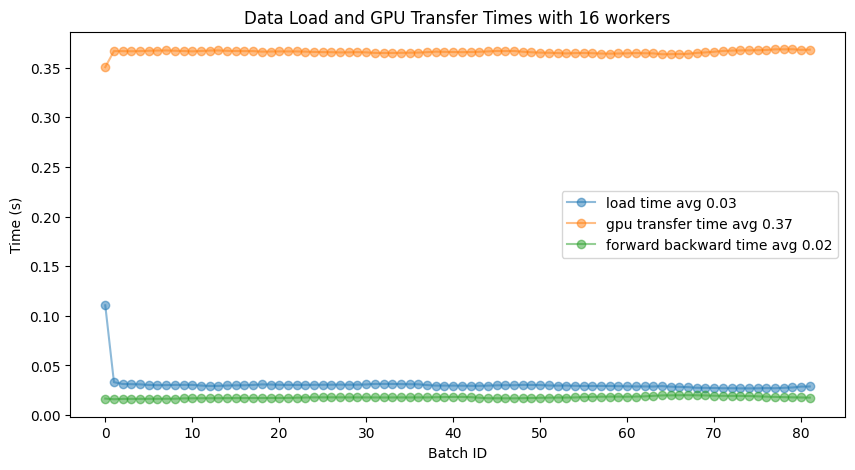

In [6]:
def time_load_transfer_train(data_loader, num_batches, rolling_window=20):
    data_load_times = []
    gpu_transfer_times = []

    forward_backward_times = []


    data_load_start_time = time.time()
    for i, (x, y) in enumerate(data_loader):
        data_load_end_time = time.time()
        data_load_time_taken = data_load_end_time - data_load_start_time
        
        data_load_times.append(data_load_time_taken)
            
        
        gpu_transfer_start_time = time.time()
        
        # transfer to GPU
        x = x.to(device)
        y = y.to(device)
        gpu_transfer_end_time = time.time()
        gpu_transfer_time_taken = gpu_transfer_end_time - gpu_transfer_start_time
        gpu_transfer_times.append(gpu_transfer_time_taken)
        
        # clear grads optimizer
        optimizer.zero_grad()

        # forward pass
        forward_backward_start_time = time.time()
        y_hat = model(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        loss.backward()
        # backward pass
        optimizer.step()

        forward_backward_end_time = time.time()

        forward_backward_time_taken = forward_backward_end_time - forward_backward_start_time 
        forward_backward_times.append(forward_backward_time_taken)   
        data_load_start_time = time.time()    

        if i == num_batches:
            break
    data_load_times = np.array(data_load_times)
    gpu_transfer_times = np.array(gpu_transfer_times)

    # apply rolling average
    data_load_times = np.convolve(data_load_times, np.ones(rolling_window)/rolling_window, mode='valid')
    gpu_transfer_times = np.convolve(gpu_transfer_times, np.ones(rolling_window)/rolling_window, mode='valid')
    forward_backward_times = np.convolve(forward_backward_times, np.ones(rolling_window)/rolling_window, mode='valid')

    return {
        "data_load_mean": np.round(np.mean(data_load_times), 2),
        "gpu_transfer_mean": np.round(np.mean(gpu_transfer_times), 2),
        "forward_backward_mean": np.round(np.mean(forward_backward_times), 2),
        "data_load_times": data_load_times,
        "gpu_transfer_times": gpu_transfer_times,
        "forward_backward_times": forward_backward_times,
    }



num_batches = 100
batch_size = 256
batch_ids = None

for num_workers in [0, 2, 4, 8, 16]:
    model = models.resnet18(pretrained=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.to(device)

    data_loader = torch.utils.data.DataLoader(tiny_imagenet_torch, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    data_load_times_dict = time_load_transfer_train(data_loader=data_loader, num_batches=num_batches)
    if batch_ids is None:
        batch_ids = np.arange(len(data_load_times_dict['data_load_times']))
    
    plt.figure(figsize=(10, 5))
    plt.plot(batch_ids, data_load_times_dict['data_load_times'], label=f"load time avg {data_load_times_dict['data_load_mean']}", marker="o", alpha=0.5)
    plt.plot(batch_ids, data_load_times_dict['gpu_transfer_times'], label=f"gpu transfer time avg {data_load_times_dict['gpu_transfer_mean']}", marker="o", alpha=0.5)
    plt.plot(batch_ids, data_load_times_dict['forward_backward_times'], label=f"forward backward time avg {data_load_times_dict['forward_backward_mean']}", marker="o", alpha=0.5)

    plt.xlabel("Batch ID")
    plt.ylabel("Time (s)")
    plt.title(f"Data Load and GPU Transfer Times with {num_workers} workers")
    plt.legend()
    plt.show()

    # clear memory
    del data_loader
    del model
    del optimizer
    torch.cuda.empty_cache()
    time.sleep(5)






## Concluding remarks
- With more workers, we were able to slash down the data load time
- Interstingly, the bottleneck is cpu to gpu transfer time. Using large batch sizes is one way to ensure to minimize number of total transfers to the GPU

- There are 100,000 images. To run one epoch, train over all samples in the dataset, with a batch size of 256. 
- Number of steps would be 100,000 / 256 = 391. For batch size 256 processing time is ~0.41 seconds, with the bottleneck being gpu transfer time. Time take to train one epoch with 256 batch size = 391 * 0.41 = 160 seconds. Time taken to train 100 epochs would be 16000 seconds or about 250 minutes.
